In [1]:
import numpy as np
import pyemma as pe
import pandas as pd
import itertools
import mdtraj as md
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
from __future__ import print_function
import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import seaborn as sns
import math
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma import config

In [3]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%run data.py

In [5]:
def unflatten(source: np.ndarray, lengths: List[int]) -> List[np.ndarray]:
    """
    Takes an array and returns a list of arrays.
    
    Parameters
    ----------
    source
        Array to be unflattened.
    lengths
        List of integers giving the length of each subarray.
        Must sum to the length of source.
    
    Returns
    -------
    unflat
        List of arrays.
    
    """
    conv = []
    lp = 0
    for arr in lengths:
        arrconv = []
        for le in arr:
            arrconv.append(source[lp:le + lp])
            lp += le
        conv.append(arrconv)
    ccs = list(itertools.chain(*conv))
    return ccs

In [6]:
def sort_lengths(flatlengths: Sequence[int], shapes: Sequence[int]) -> List[List[int]]:
    """
    Takes a list of lengths and returns a list of lists of lengths.
    
    Parameters
    ----------
    flatlengths
        List of lengths
    shapes
        List of shapes
    
    Returns
    -------
    lengths
        List of lists of lengths
    
    """
    lengths = []
    i = 0
    for n in shapes:
        arr = []
        for _ in range(n):
            arr.append(flatlengths[i])
            i += 1
        lengths.append(arr)
    return lengths

In [7]:
def idx_to_traj(idx: int, lengths: List[int]) -> Tuple[int, int]:
    """
    Given a trajectory index, find the round and trajectory file number.
    
    Parameters
    ----------
    idx
        Trajectory index
    lengths
        Length of each round
    
    Returns
    -------
    round, number
        Simulation round and corresponding trajectory number
    
    """
    lengths = np.array(lengths)
    lcs = lengths.cumsum()
    if idx >= lengths[0]:
        nr = idx - lcs[lcs < idx][-1]
        i = np.arange(len(lengths))[lcs > idx][0]
    else:
        i, nr = 0, idx
    return i, nr

In [8]:
def weighted_avg_and_std(values):
    average = np.average(values)
    variance = np.average((values-average)**2)
    return (math.sqrt(variance))

In [9]:
def difference(x,y):
    done=x-y
    return (abs(done))

In [11]:
c_AB = (0.7686, 0.4196, 0.1882, 1)   #set color for AB points
e_AB = (0.7686, 0.4196, 0.1882, 0.5) #set color for AB errors
c_G5 = (0.3725, 0.5804, 0.4588, 1)   #set color for AB+10074-G5 points
e_G5 = (0.3725, 0.5804, 0.4588, 0.5) #set color for AB+10074-G5 errors
blue_dark  = (0.4392, 0.5961, 0.8196) #set dark blue
blue_light = (0.6549, 0.7765, 0.8941) #set light blue
red_dark   = (0.4431, 0.1059, 0.0941) #set dark red
red_light  = (0.6392, 0.4118, 0.3882) #set light red


In [12]:
lengths=100
n_reps=32
ab_seq_no_ter = 'AEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVI'

In [14]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [17]:
sim_names = ('ligandA',"ligandB", "ligandD")

top, trajs = {}, {}
trajfir={k: "/pool/work/adelie/results_G5_der/input_data/trajectories/firsthalf{0}.xtc".format(k) for k in sim_names}
trajsec={k: "/pool/work/adelie/results_G5_der/input_data/trajectories/secondhalf{0}.xtc".format(k) for k in sim_names}
top = {k: "/pool/work/adelie/results_G5_der/input_data/topology/{0}.gro".format(k) for k in sim_names}
weight={k: "/pool/work/adelie/results_G5_der/input_data/weights/{0}_weights".format(k) for k in sim_names}



#a_bias={k: "/pool/work/adelie/results_G5_der/input_data/topology/{0}/r?/*.gro".format(k) for k in 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


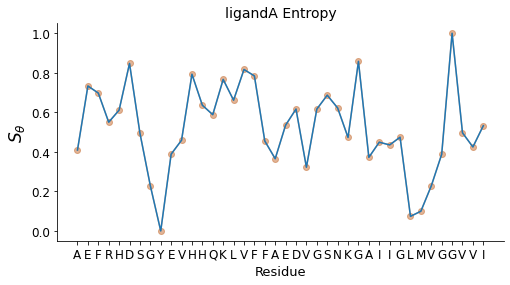

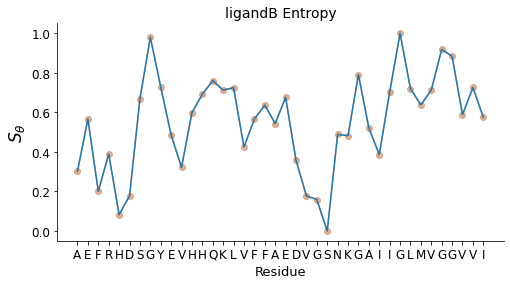

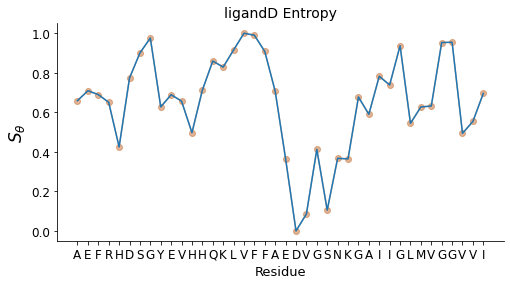

In [20]:
lengths=100
n_reps=32
ab_seq_no_ter = 'AEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVI'

for k in (sim_names):
    tAB = md.load(trajfir[k],top=top[k])
    tABsec = md.load(trajsec[k],top=top[k])
#Calculate phi values for each trajectory
    _,phi_AB = md.compute_phi(tAB, periodic=False) #First half of the trajectory
    _,phi_ABsec = md.compute_phi(tABsec, periodic=False) #Second half of the trajectory


#Calculate psi values for each trajectory
    _,psi_AB = md.compute_psi(tAB, periodic=False)
    _,psi_ABsec = md.compute_psi(tABsec, periodic=False)

    AB_rama_ent = np.zeros((41))
    bins=[np.linspace(-np.pi, np.pi, num=100), np.linspace(-np.pi, np.pi, num=100)]
    
#Caluclate Weights
    a_bias=np.genfromtxt(weight[k])
    a_df=pd.DataFrame(a_bias[:,-1])
    weight_a = np.array(a_df.apply(lambda x: math.exp(x/2.311420), axis=1))
    
    
##there are 41 total different phi and psi angles
    for i in range (0, 40):
        counts, xedges, yedges = np.histogram2d(phi_AB[:, i], psi_AB[:, i+1], bins=bins, density=True, weights=weight_a)
        data = counts.flatten()
        ent_AB = -(data*np.ma.log(np.abs(data))).sum()
        AB_rama_ent[i] = ent_AB
        listyfir=AB_rama_ent[-42:-1]
        
        countsec, xedgesec, yedgesec = np.histogram2d(phi_ABsec[:, i], psi_ABsec[:, i+1], bins=bins, density=True) #,weights=weight_a)
        datasec = countsec.flatten()
        ent_ABsec = -(datasec*np.ma.log(np.abs(datasec))).sum()
        AB_rama_ent[i] = ent_ABsec
        listysec=AB_rama_ent[-42:-1]
        
        total_1_axisfir=NormalizeData(listyfir)
        total_1_axissec=NormalizeData(listysec)

        var=difference(total_1_axisfir,total_1_axissec)
        con3=(np.array(total_1_axisfir) + np.array(total_1_axissec)) / 2.0


        

#Plotting
    labels = np.arange(0, 40)
    
    Y = np.asarray(con3)

    x = np.arange(len(labels))  # the label locations
    width = 0.8  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 4))
    rects = ax.plot(x, Y, marker='o',color=e_AB)
    plt.errorbar(y=Y, x=x, yerr=var,ecolor=c_AB)# fmt="o")


# Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('$S_{\u03B8}$', fontsize=17)
    ax.set_title("{} Entropy".format(k),fontsize=14)
    ax.set_xlabel('Residue', fontsize=13)

    ax.set_xticks(x)
    ax.xaxis.tick_bottom()
    ax.set_xticklabels(list(ab_seq_no_ter))    

#fig.tight_layout()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(frameon=False);

